In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
import tqdm
import sys
import os
import gc
import argparse
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2）探索性数据分析（EDA）
# 在数据准备阶段，主要读取训练数据和测试数据，并进行基本的数据展示。
# 加载数据
train = pd.read_csv('data/dataset/train.csv')
print("Train data is:")
print(train.head())
test = pd.read_csv('data/dataset/test.csv')
print("Test data is:")
print(test.head())

Train data is:
           id  dt  type  target
0  00037f39cf  11     2  44.050
1  00037f39cf  12     2  50.672
2  00037f39cf  13     2  39.042
3  00037f39cf  14     2  35.900
4  00037f39cf  15     2  53.888
Test data is:
           id  dt  type
0  00037f39cf   1     2
1  00037f39cf   2     2
2  00037f39cf   3     2
3  00037f39cf   4     2
4  00037f39cf   5     2


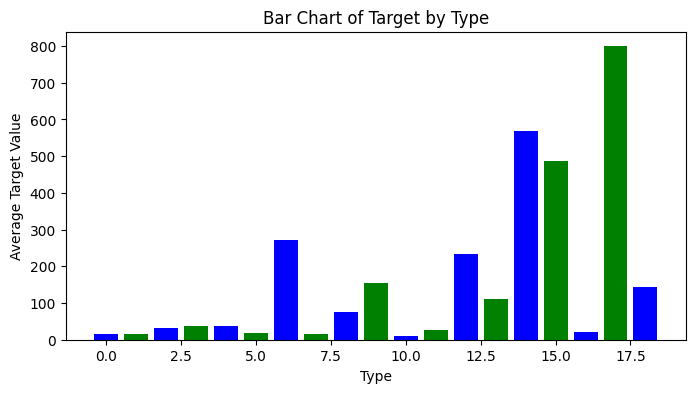

In [3]:
import matplotlib.pyplot as plt
# 可视化角度查看一下不同类型家庭Target均值差异
# 不同type类型对应target的柱状图
type_target_df = train.groupby('type')['target'].mean().reset_index()
plt.figure(figsize=(8, 4))
plt.bar(type_target_df['type'], type_target_df['target'], color=['blue', 'green'])# 默认bins=10
plt.xlabel('Type')
plt.ylabel('Average Target Value')
plt.title('Bar Chart of Target by Type')
plt.show()

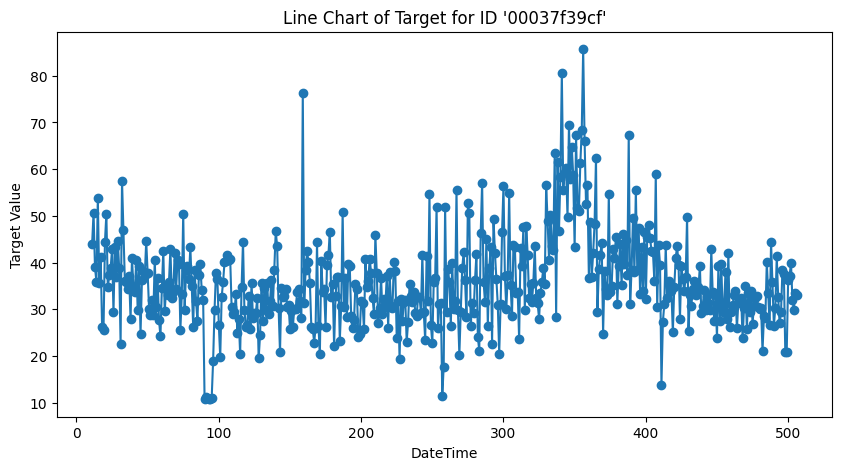

In [4]:
# 选出00037f39cf作为代表进行可视化分析
specific_id_df = train[train['id'] == '00037f39cf']
plt.figure(figsize=(10, 5))
plt.plot(specific_id_df['dt'], specific_id_df['target'], marker='o', linestyle='-')
plt.xlabel('DateTime')
plt.ylabel('Target Value')
plt.title("Line Chart of Target for ID '00037f39cf'")
plt.show()

In [5]:
# 合并训练数据和测试数据，并进行排序
# 将test和train数据沿着行方向（axis=0）进行合并，并忽略原有的索引（ignore_index=True），生成新的DataFrame data。
# 这样做的目的是将两个数据集整合到一个DataFrame中，便于后续的统一处理。
data = pd.concat([test, train], axis=0, ignore_index=True)
#
print("前5行数据")
print(data.head())

# 按id和dt（日期时间）列进行降序排序，确保每个id的记录按时间逆序排列。
# .reset_index(drop=True): 重置索引，删除旧的索引并生成新的连续索引。
data = data.sort_values(['id','dt'], ascending=False).reset_index(drop=True)
# 
print("前5行数据")
print(data.head())

前5行数据
           id  dt  type  target
0  00037f39cf   1     2     NaN
1  00037f39cf   2     2     NaN
2  00037f39cf   3     2     NaN
3  00037f39cf   4     2     NaN
4  00037f39cf   5     2     NaN
前5行数据
           id   dt  type  target
0  fff81139a7  506     5  18.145
1  fff81139a7  505     5  22.021
2  fff81139a7  504     5  21.282
3  fff81139a7  503     5  22.818
4  fff81139a7  502     5  28.552


In [6]:
# 排序是为了确保后续的历史平移和窗口统计特征的生成基于正确的时间顺序。

# 历史平移
# for i in range(10, 30): 设定一个循环，从10到29，生成一系列的历史特征。-这是一个比较稳妥的范围设置
# data.groupby(['id'])['target'].shift(i): 对每个id进行分组，然后对target列进行平移，生成滞后i步的特征。
# data[f'last{i}_target']: 将生成的滞后特征存储到新的列last{i}_target中。
for i in range(10,30):
    data[f'last{i}_target'] = data.groupby(['id'])['target'].shift(i)
# 那既然这样说——我们可以把周的因素考虑进去   
# 比如每7天滞后一次？-没关系，反正先生成
# 窗口统计
# 计算last10_target、last11_target和last12_target的平均值，并赋值给新的特征win3_mean_target。

data[f'win3_mean_target'] = (data['last10_target'] + data['last11_target'] + data['last12_target']) / 3
data[f'win7_mean_target'] = (data['last13_target'] + data['last14_target'] + data['last15_target']) / 3

# 计算更多的窗口统计特征
for window in [4,10]:
    data[f'win{10+window}_mean_target'] = data[['last' + str(i) + '_target' for i in range(10, 10 + window)]].mean(axis=1)
    data[f'win{10+window}_std_target'] = data[['last' + str(i) + '_target' for i in range(10, 10 + window)]].std(axis=1)
    # data[f'win{window}_max_target'] = data[['last' + str(i) + '_target' for i in range(10, 10 + window)]].max(axis=1)
    # data[f'win{window}_min_target'] = data[['last' + str(i) + '_target' for i in range(10, 10 + window)]].min(axis=1)

# 进行数据切分
# 选取了所有target值非空的记录，并重置索引，生成训练数据train。
train = data[data.target.notnull()].reset_index(drop=True)
print("train前5行数据")
print(train.head())

# 选取了所有target值为空的记录，并重置索引，生成测试数据test。
test = data[data.target.isnull()].reset_index(drop=True)
print("test前5行数据")
print(test.head())

# 确定输入特征
# 使用列表推导式选取data中的所有列名，排除id和target列，生成用于模型训练的特征列表train_cols。
train_cols = [f for f in data.columns if f not in ['id','target']]
print("列名")
print(train_cols)

train前5行数据
           id   dt  type  target  last10_target  last11_target  last12_target  \
0  fff81139a7  506     5  18.145            NaN            NaN            NaN   
1  fff81139a7  505     5  22.021            NaN            NaN            NaN   
2  fff81139a7  504     5  21.282            NaN            NaN            NaN   
3  fff81139a7  503     5  22.818            NaN            NaN            NaN   
4  fff81139a7  502     5  28.552            NaN            NaN            NaN   

   last13_target  last14_target  last15_target  ...  last26_target  \
0            NaN            NaN            NaN  ...            NaN   
1            NaN            NaN            NaN  ...            NaN   
2            NaN            NaN            NaN  ...            NaN   
3            NaN            NaN            NaN  ...            NaN   
4            NaN            NaN            NaN  ...            NaN   

   last27_target  last28_target  last29_target  win3_mean_target  \
0            

In [7]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from lightgbm import log_evaluation, early_stopping
# verbose_eval: 每500次迭代输出一次结果。
# early_stopping_rounds: 如果在500次迭代后模型性能没有提升，则停止训练。
callbacks = [log_evaluation(period=500), early_stopping(stopping_rounds=500)]

# 受四个参数：lgb（LightGBM库），train_df（训练数据），test_df（测试数据），以及cols（特征列名）。
def time_model(lgb, train_df, test_df, cols):

    # 训练集和验证集切分
    # rn_x和trn_y：包含dt大于等于31的记录，这部分数据作为训练集。
    # val_x和val_y：包含dt小于等于30的记录，这部分数据作为验证集。
    trn_x, trn_y = train_df[train_df.dt>=31][cols], train_df[train_df.dt>=31]['target']
    val_x, val_y = train_df[train_df.dt<=30][cols], train_df[train_df.dt<=30]['target']
    # 目的是模拟实际预测中的时间顺序，使用未来的数据（dt>=31）来预测过去的数据（dt<=30），从而评估模型的性能。
    #
    # 构建模型输入数据
    # 将训练集和验证集数据转换为LightGBM的Dataset格式，分别为train_matrix和valid_matrix。这种格式是LightGBM训练模型所需的输入格式。
    train_matrix = lgb.Dataset(trn_x, label=trn_y)
    valid_matrix = lgb.Dataset(val_x, label=val_y)

    # lightgbm参数
    lgb_params = {
        'boosting_type': 'gbdt',  #使用基于决策树的梯度提升方法（gbdt）
        'objective': 'regression',#目标函数为回归（regression）
        'metric': 'mse',          #评估指标为均方误差（mse）
        'min_child_weight': 5,    #每个叶子节点的最小样本权重，防止过拟合
        'num_leaves': 2 ** 5,     #树的最大叶子节点数
        'lambda_l2': 10,          #L2正则化的惩罚系数，防止过拟合
        'feature_fraction': 0.8,  #每次迭代时使用的特征比例
        'bagging_fraction': 0.8,  #每次迭代时使用的数据比例
        'bagging_freq': 4,        #每4次迭代执行一次bagging
        'learning_rate': 0.05,    #学习率
        'seed': 2024,             #随机种子
        'nthread' : 16,           #使用线程数
        'verbose' : -1,           #控制训练过程的输出信息
    }

    # 使用GridSearchCV进行参数调优
    # 定义了需要调优的参数及其取值范围
    param_grid = {
        'num_leaves': [20, 31, 40],         #决策树的最大叶子节点数。增加叶子节点数可以使模型更复杂，从而捕捉更多的模式，但也可能导致过拟合。
        'learning_rate': [0.01, 0.05, 0.1], #学习率，控制每次迭代更新步长。较小的学习率可以使模型更稳定，但需要更多的迭代次数
        'feature_fraction': [0.8, 0.9, 1.0],#每次迭代时使用的特征比例。减少特征数量可以防止过拟合
        'bagging_fraction': [0.8, 0.9, 1.0],#每次迭代时使用的数据比例。减少样本数量可以防止过拟合
        'lambda_l2': [0, 5, 10]             # L2正则化惩罚系数，增加这个值可以防止过拟合
    }

    # 初始化LightGBM回归器lgb_estimator，传入初始参数lgb_params。
    # 这里的lgb_params是之前定义的参数集，除了在网格搜索中需要调优的参数外，其他参数保持不变。
    lgb_estimator = lgb.LGBMRegressor(**lgb_params)
    
    # 初始化GridSearchCV对象：
    # estimator=lgb_estimator: 使用LightGBM回归器作为基模型。
    # param_grid=param_grid: 设置需要调优的参数网格。
    # scoring='neg_mean_squared_error': 评估指标为负的均方误差（因为GridSearchCV默认寻找得分最高的参数组合，而我们希望均方误差最小）。
    # cv=3: 使用3折交叉验证。
    # verbose=1: 输出详细的调优过程信息。
    # n_jobs=-1: 使用所有可用的CPU核进行并行计算。
    gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
    
    # 运行网格搜索，找到最优的参数组合。
    # fit方法对每个参数组合进行训练和评估，找到使均方误差最小的参数组合。
    gsearch.fit(trn_x, trn_y)

    # 输出网格搜索找到的最佳参数组合和对应的最佳交叉验证得分（负均方误差的负值，即均方误差的正值）。
    # 打印最佳参数和最佳得分
    print("Best parameters found by grid search:", gsearch.best_params_)
    print("Best CV score:", -gsearch.best_score_)

    # 使用最佳参数训练模型
    best_params = gsearch.best_params_

    # 训练模型
    model = lgb.train(best_params, # 模型参数
                      train_matrix, # 训练数据集
                      50000, #最大迭代次数
                      valid_sets=[train_matrix, valid_matrix], #验证数据集，用于评估模型性能
                      categorical_feature=[], #指定哪些特征是分类特征（这里为空）---其实我们前面最好对type使用独热编码吗?
                      callbacks=callbacks
                      )
    
    # 使用训练好的模型对验证集和测试集进行预测：
    # 验证集和测试集结果预测
    # 验证集的预测结果
    # num_iteration=model.best_iteration 使用模型的最佳迭代次数进行预测。
    val_pred = model.predict(val_x, num_iteration=model.best_iteration)
    # 测试集的预测结果
    test_pred = model.predict(test_df[cols], num_iteration=model.best_iteration)


    # 离线分数评估
    # 计算验证集的均方误差（MSE）评估模型性能，并输出评估结果。
    score = mean_squared_error(val_pred, val_y)
    print(score)
       
    return val_pred, test_pred
    
lgb_oof, lgb_test = time_model(lgb, train, test, train_cols)

# 保存结果文件到本地
test['target'] = lgb_test
test[['id','dt','target']].to_csv('submit.csv', index=None)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


KeyboardInterrupt: 